In [1]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [7]:
for root, dirs, files in os.walk('imgs_align'):
    print(root, dirs, files)
    print(os.path.join('save_folder', os.path.relpath(root, 'imgs_align')))
    for file in files:
        print(os.path.splitext(file)[0])
        print(os.path.join("save_folder", os.path.splitext(file)[0]))

imgs_align [] ['00002.png', '00010.png', 'sandy.png', '00009.png', '00001.png', '00006.png', '00005.png', '00003.png', '00007.png', '00000.png', '00008.png', '00004.png']
save_folder/.
00002
save_folder/00002
00010
save_folder/00010
sandy
save_folder/sandy
00009
save_folder/00009
00001
save_folder/00001
00006
save_folder/00006
00005
save_folder/00005
00003
save_folder/00003
00007
save_folder/00007
00000
save_folder/00000
00008
save_folder/00008
00004
save_folder/00004


In [48]:
import torch
from torchvision.utils import save_image
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel
import clip
from PIL import Image

import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')
from Losses import id_loss

device ="cuda" if torch.cuda.is_available() else "cpu"

#----------------Load FaRL and Arcface model----------------------#
FaRL_model, preprocess = clip.load("ViT-B/16", device="cpu")
FaRL_model = FaRL_model.to(device)
FaRL_state=torch.load("FaRL/checkpoints/FaRL-Base-Patch16-LAIONFace20M-ep64.pth") # you can download from https://github.com/FacePerceiver/FaRL#pre-trained-backbones
FaRL_model.load_state_dict(FaRL_state["state_dict"],strict=False)
FaRL_model.eval()

def extract_features(image_folder, save_folder):
    # 创建保存文件夹
    os.makedirs(save_folder, exist_ok=True)
    # 创建保存文件夹名称的txt文件
    txt_file = os.path.join(save_folder, "folder_names.txt")
    with open(txt_file, "w") as f:
        pass

    # 图像预处理
    FaRL_transform0 = transforms.Compose([
        transforms.Resize(size=224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(size=224),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                             std=(0.26862954, 0.26130258, 0.27577711))
    ])

    # 遍历图片文件夹
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            # 读取图片
            image_path = os.path.join(root, file)
            image = Image.open(image_path).convert("RGB")
            # 图像预处理
            img_preprocess = transforms.ToTensor()
            image_tensor = img_preprocess(image).unsqueeze(0).cuda()

            # 使用模型提取特征
            with torch.no_grad():
                features = FaRL_model.visual(FaRL_transform0(image_tensor))

            # 保存图片和特征
            image_name = os.path.splitext(file)[0]
            # 创建保存图片和特征的子文件夹
            group_folder = os.path.join(save_folder, image_name)
            os.makedirs(group_folder, exist_ok=True)
            image_save_path = os.path.join(group_folder, image_name + ".jpg")
            feature_save_path = os.path.join(group_folder, image_name + ".pt")

            image.save(image_save_path)
            torch.save(features, feature_save_path)

            # 写入文件夹名称到txt文件
            with open(txt_file, "a") as f:
                f.write(group_folder + "\n")



In [13]:
test_path = 'imgs_align' # dataset to test the framework
data = ImageDataset(test_path, image_size=256, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
print('The number of the data:', len(data))

The number of the data: 12


In [14]:
batch = data[10]['img'][None]
in_image = batch.cuda()  # (range:[-1,1]; size:[1,3,256,256])

# Real Data
Real_image = (in_image + 1) / 2 # (range:[0,1]; size:[1,3,256,256])

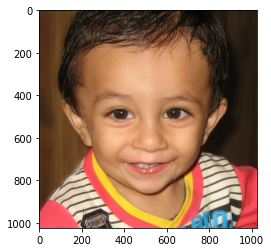

In [38]:
import matplotlib.pyplot as plt
plt.imshow(image_tensor[0].permute(1, 2, 0).cpu())

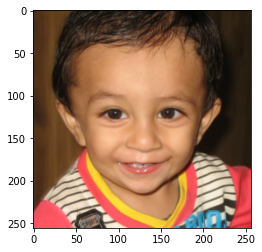

In [39]:
plt.imshow(Real_image[0].permute(1, 2, 0).cpu())

In [34]:
Real_image

tensor([[[[0.3176, 0.3059, 0.2980,  ..., 0.1647, 0.1647, 0.1608],
          [0.3255, 0.3137, 0.2980,  ..., 0.1608, 0.1686, 0.1608],
          [0.3294, 0.3176, 0.3020,  ..., 0.1569, 0.1608, 0.1569],
          ...,
          [0.9686, 0.9725, 0.9843,  ..., 0.8314, 0.8314, 0.8314],
          [0.9725, 0.9804, 0.9882,  ..., 0.8235, 0.8353, 0.8392],
          [0.9804, 0.9843, 0.9882,  ..., 0.8314, 0.8471, 0.8627]],

         [[0.1922, 0.1882, 0.1843,  ..., 0.1176, 0.1176, 0.1176],
          [0.1922, 0.1843, 0.1765,  ..., 0.1216, 0.1216, 0.1176],
          [0.1922, 0.1882, 0.1843,  ..., 0.1176, 0.1216, 0.1176],
          ...,
          [0.3137, 0.3137, 0.3176,  ..., 0.2000, 0.1922, 0.1804],
          [0.3176, 0.3216, 0.3216,  ..., 0.1882, 0.1882, 0.1843],
          [0.3255, 0.3255, 0.3255,  ..., 0.1843, 0.1882, 0.1961]],

         [[0.0980, 0.0941, 0.0941,  ..., 0.0706, 0.0745, 0.0706],
          [0.0980, 0.0941, 0.0902,  ..., 0.0627, 0.0667, 0.0667],
          [0.1020, 0.0980, 0.0941,  ..., 0

In [46]:
image_tensor.min()

tensor(0., device='cuda:0')

In [43]:
FaRL_transform0 = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                             std=(0.26862954, 0.26130258, 0.27577711))
    ])

image_path = os.path.join("imgs_align", "00010.png")
image = Image.open(image_path).convert("RGB")
img_preprocess = transforms.ToTensor()
image_tensor = img_preprocess(image).unsqueeze(0).cuda()
with torch.no_grad():
    features = FaRL_model.visual(FaRL_transform0(image_tensor))

In [47]:
features = FaRL_model.visual(FaRL_transform0(Real_image))
features.size()

torch.Size([1, 512])

In [44]:
features

tensor([[ 3.5744e-01, -9.2937e-02,  3.5587e-02, -1.4162e-02,  4.6300e-02,
         -1.4494e-01, -2.1593e-01,  8.9451e-02, -2.1137e-01, -8.3019e-02,
          4.7029e-02, -2.4985e-02, -2.2850e-02,  6.9117e-02, -1.0578e-01,
          1.2912e-01,  2.5484e-01,  1.0442e-01,  3.2274e-02, -1.4865e-01,
         -3.4159e-02, -3.3289e-02,  2.5365e-01, -2.5653e-02,  3.0707e-02,
         -2.7419e-01,  1.0159e-01,  1.0299e-01,  3.3366e-02,  1.1354e-01,
         -1.3675e-01,  1.0175e-01,  1.5490e-01,  2.6823e-01, -1.1739e-01,
          3.4359e-03, -3.3196e-02,  1.3716e-01,  2.8025e-01,  4.7719e-02,
         -6.7923e-02, -8.7699e-02,  2.1788e-01, -1.4974e-01, -4.1214e-02,
         -1.2994e-02, -3.1003e-01, -2.0089e-02, -1.9966e-01, -6.2299e-03,
          1.1579e-01,  5.1009e-02, -1.8403e-01,  2.3191e-01,  7.6194e-02,
          4.2325e-01,  1.7427e-01,  5.5873e-02, -1.6663e-01, -2.0049e-01,
         -5.0432e-02, -1.7020e-01, -2.1474e-01,  1.9548e-01,  7.3526e-02,
          3.2502e-01, -4.2828e-02,  1.

In [49]:
# 示例用法
image_folder = "imgs_align"  # 输入图片文件夹
save_folder = "save_folder"  # 保存文件夹

extract_features(image_folder, save_folder)